In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import random


In [3]:
path = Path('UTKFace')

In [4]:
def extract_age(filename):
    return float(filename.stem.split('_')[0])

In [5]:
def load_face_data(img_size, batch_size):
    tfms = get_transforms(max_warp=0.)
    return (ImageItemList.from_folder(path)
            .random_split_by_pct(0.1, seed=666)
            .label_from_func(extract_age)
            .transform(tfms, size=img_size)
            .databunch(bs=batch_size))

In [6]:
data = load_face_data(128, 256)

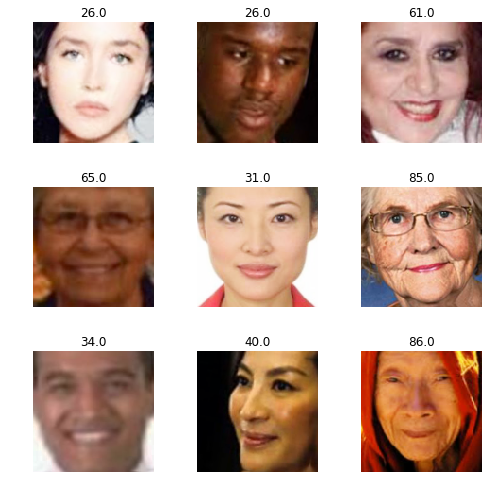

In [18]:
data.show_batch(rows=3, figsize=(7,7))

In [8]:
layers = list(models.resnet18(pretrained=True).children())[:-2]
layers += [AdaptiveConcatPool2d(),Flatten(),nn.Linear(1024, 16), nn.ReLU(), nn.Linear(16,1)]

In [9]:
model = nn.Sequential(*layers)

In [10]:
learn = Learner(data, model, loss_func = F.l1_loss)

In [11]:
learn.split([model[-3]])

In [12]:
learn.layer_groups[-1]

Sequential(
  (0): Linear(in_features=1024, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=1, bias=True)
)

In [13]:
learn.freeze_to(-1)

In [14]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss
1,18.091930,15.392178
2,15.618636,15.220136
3,15.236475,15.201498


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


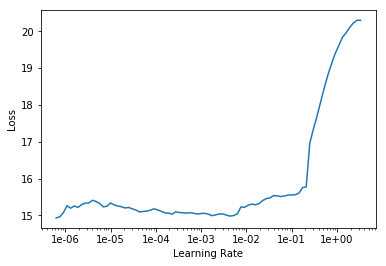

In [15]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [16]:

learn.fit_one_cycle(12, max_lr = slice(1e-4,1e-2))

epoch,train_loss,valid_loss
1,15.120690,15.127304
2,15.092578,15.348733
3,15.106189,15.116929
4,15.069721,15.300779
5,15.057093,15.203197
6,15.059254,15.139565
7,15.077569,15.058936
8,14.963204,15.063331
9,15.045466,15.086802
10,14.994682,15.058257


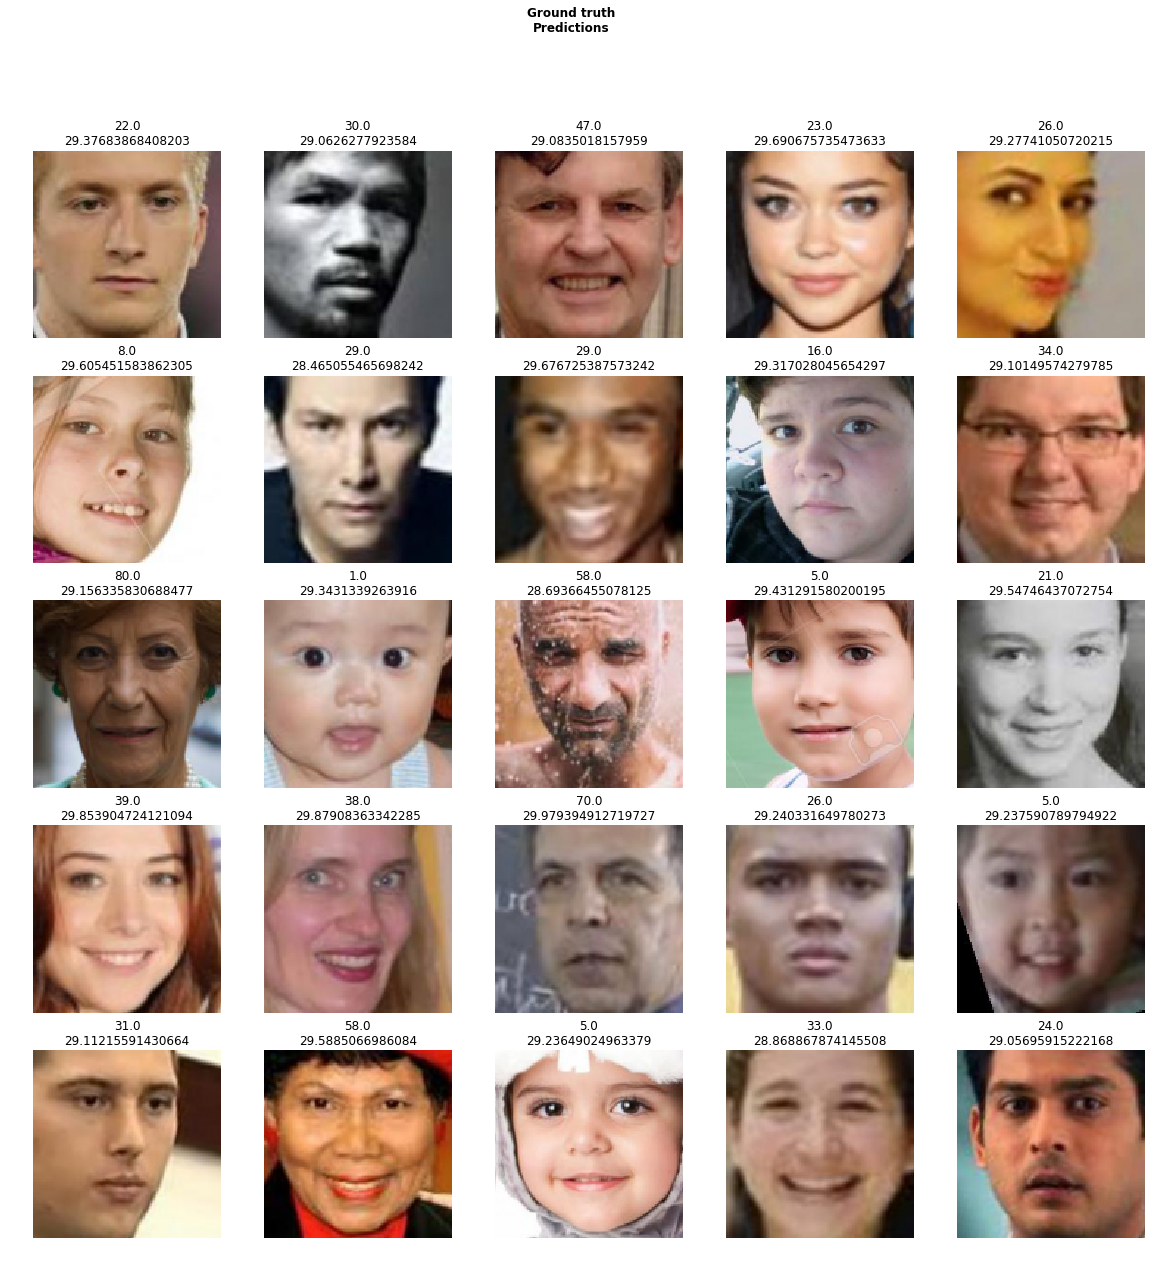

In [17]:
learn.show_results()

In [19]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [256, 64, 64, 64]    9408       True      
______________________________________________________________________
BatchNorm2d          [256, 64, 64, 64]    128        True      
______________________________________________________________________
ReLU                 [256, 64, 64, 64]    0          False     
______________________________________________________________________
MaxPool2d            [256, 64, 32, 32]    0          False     
______________________________________________________________________
Conv2d               [256, 64, 32, 32]    36864      True      
______________________________________________________________________
BatchNorm2d          [256, 64, 32, 32]    128        True      
______________________________________________________________________
ReLU                 [256, 64, 32, 32]    0          False     
______________________________________________________________